Import Libraries

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge, Lasso, ElasticNet,LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
import xgboost as xgb
import lightgbm as lgb
import shap
import optuna
import warnings
import joblib
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)


Loading Data

In [14]:
def load_housing_data():
    dataset = fetch_california_housing()
    
    # Convert to pandas DataFrame
    df = pd.DataFrame(data=dataset.data, columns=dataset.feature_names)
    df['PRICE'] = dataset.target  # Add target variable
    
    # Add an ID column for consistency with competition formats
    df['Id'] = range(1, len(df) + 1)
    
    print("California Housing dataset loaded successfully.")
    print(f"Dataset shape: {df.shape}")
    
    # Split into train and test (80/20)
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
    train_df = train_df.reset_index(drop=True)
    test_df = test_df.reset_index(drop=True)
    
    test_target = test_df['PRICE'].copy()
    test_df = test_df.drop('PRICE', axis=1)  # Remove target from test
    
    return df, train_df, test_df, test_target

# Load the data
df, train_df, test_df, test_target = load_housing_data()


California Housing dataset loaded successfully.
Dataset shape: (20640, 10)


In [15]:
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,PRICE,Id
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526,1
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585,2
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521,3
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413,4
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422,5


In [10]:
train_df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,PRICE,Id
0,3.2596,33.0,5.017657,1.006421,2300.0,3.691814,32.71,-117.03,1.030,14197
1,3.8125,49.0,4.473545,1.041005,1314.0,1.738095,33.77,-118.16,3.821,8268
2,4.1563,4.0,5.645833,0.985119,915.0,2.723214,34.66,-120.48,1.726,17446
3,1.9425,36.0,4.002817,1.033803,1418.0,3.994366,32.69,-117.11,0.934,14266
4,3.5542,43.0,6.268421,1.134211,874.0,2.300000,36.78,-119.80,0.965,2272


In [12]:
test_df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Id
0,1.6812,25.0,4.192201,1.022284,1392.0,3.877437,36.06,-119.01,20047
1,2.5313,30.0,5.039384,1.193493,1565.0,2.679795,35.14,-119.46,3025
2,3.4801,52.0,3.977155,1.185877,1310.0,1.360332,37.80,-122.44,15664
3,5.7376,17.0,6.163636,1.020202,1705.0,3.444444,34.28,-118.72,20485
4,3.7250,34.0,5.492991,1.028037,1063.0,2.483645,36.62,-121.93,9815


In [13]:
test_target.head()

0    0.47700
1    0.45800
2    5.00001
3    2.18600
4    2.78000
Name: PRICE, dtype: float64

Exploratory Data Analysis

In [16]:
df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,PRICE,Id
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558,10320.500000
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956,5958.399114
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990,1.000000
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000,5160.750000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000,10320.500000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250,15480.250000
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010,20640.000000


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
 8   PRICE       20640 non-null  float64
 9   Id          20640 non-null  int64  
dtypes: float64(9), int64(1)
memory usage: 1.6 MB


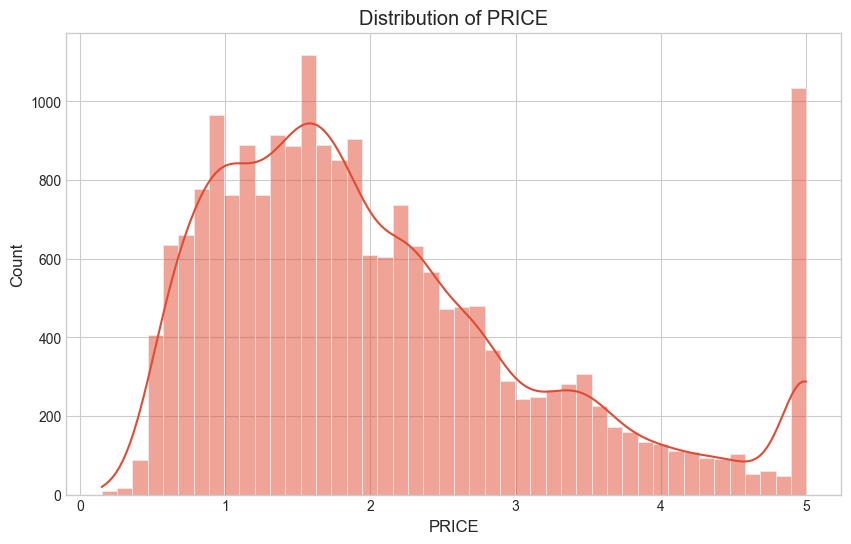

In [19]:
plt.figure(figsize=(10, 6))
sns.histplot(df['PRICE'], kde=True)
plt.title(f'Distribution of {df.columns[-2]}')
plt.show()

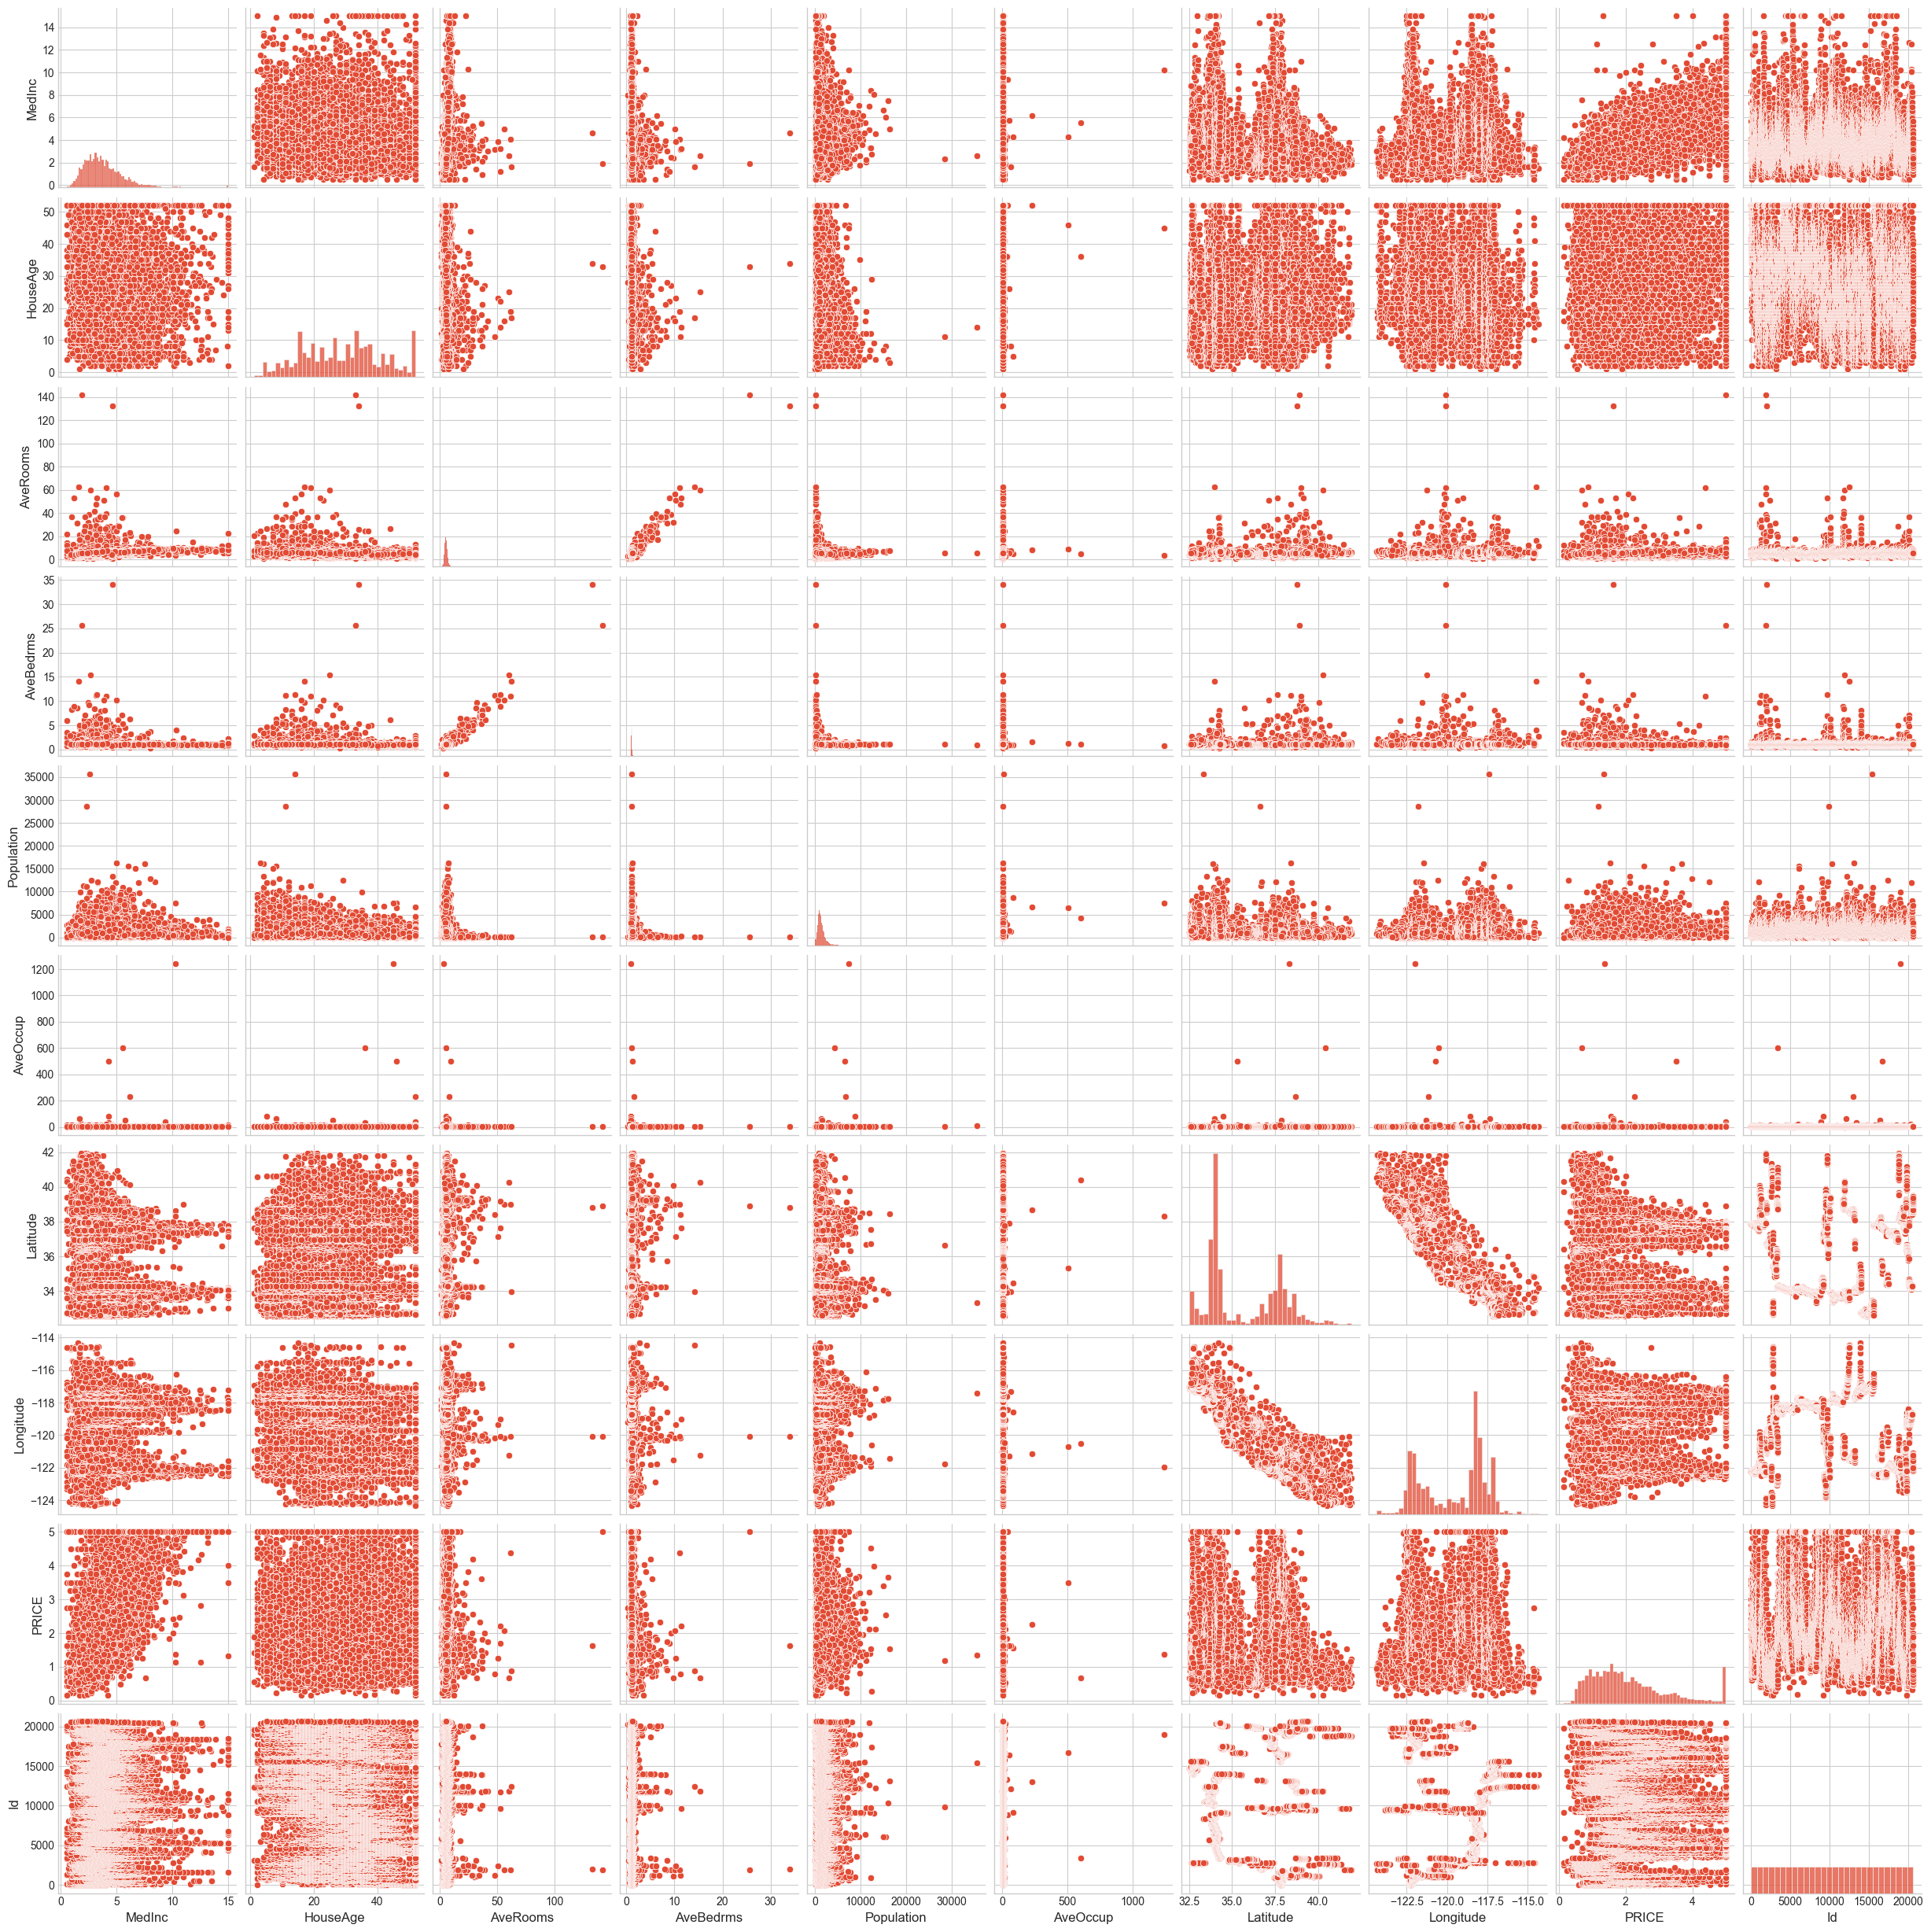

In [20]:
sns.pairplot(df)

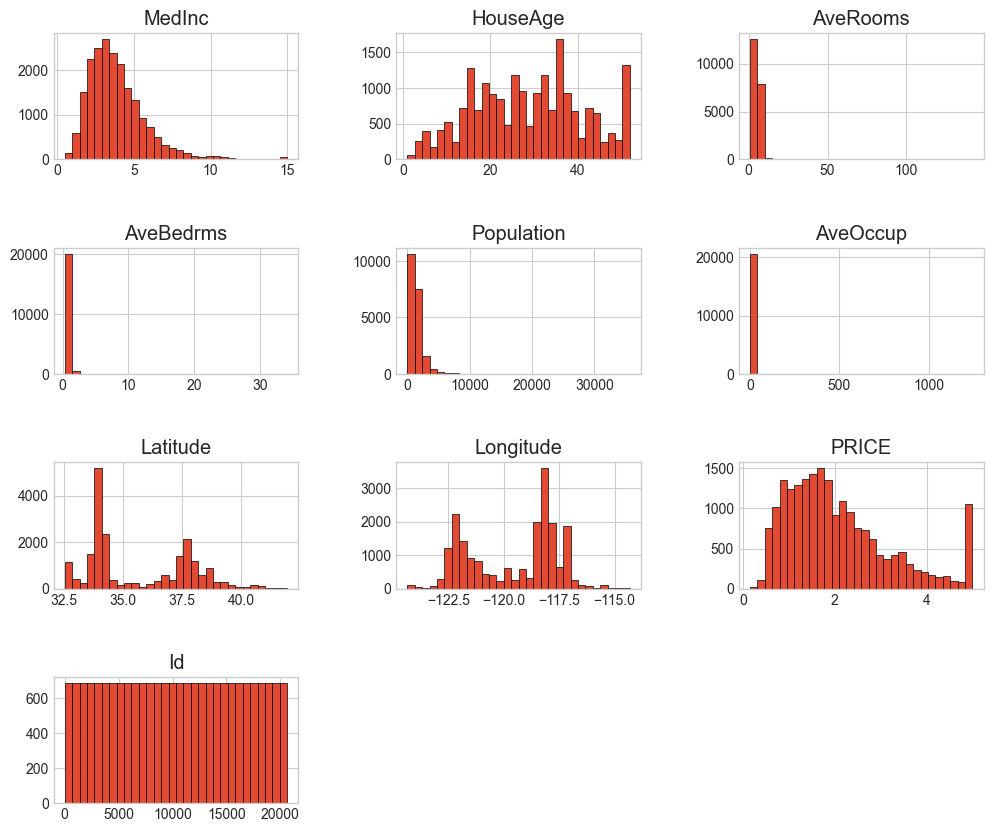

In [21]:

df.hist(figsize=(12, 10), bins=30, edgecolor="black")
plt.subplots_adjust(hspace=0.7, wspace=0.4)

<Axes: >

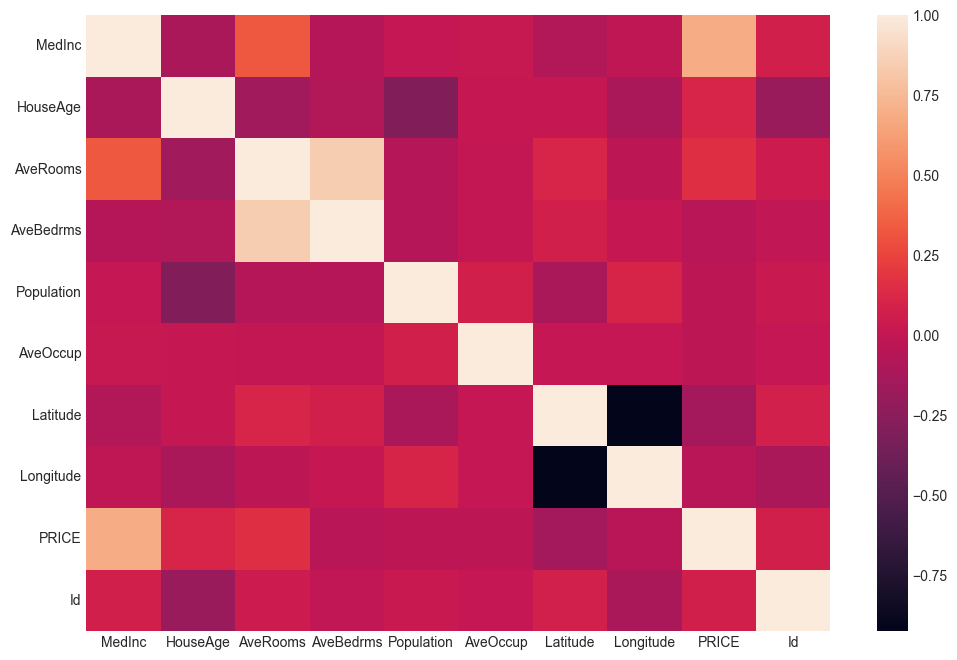

In [23]:
sns.heatmap(df.corr())

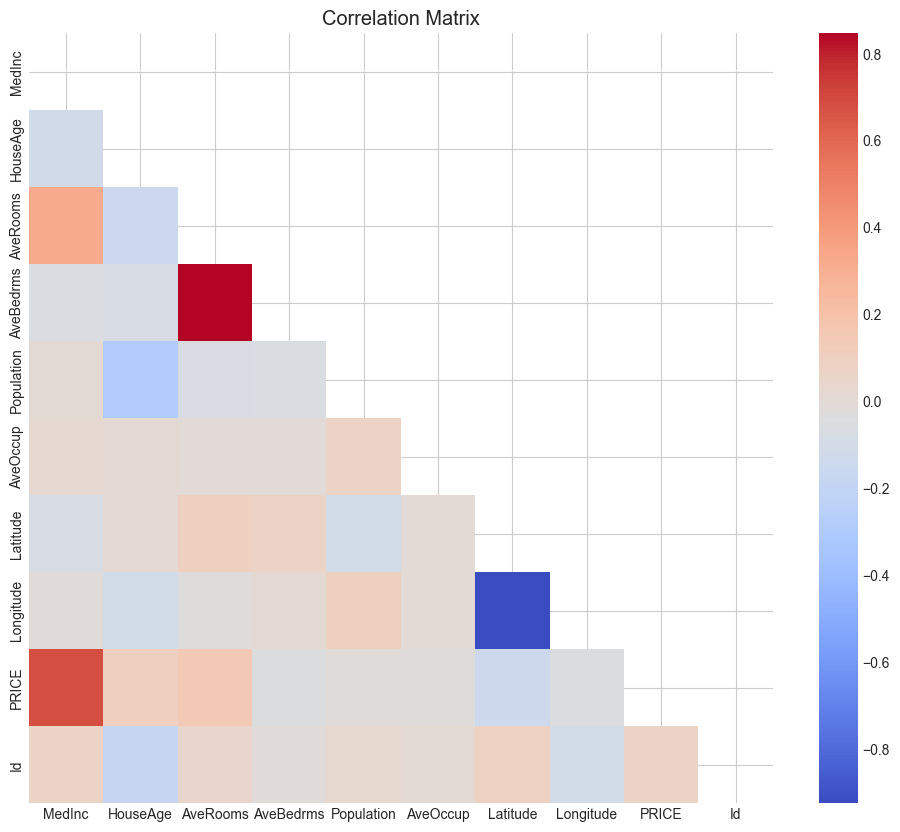

In [22]:
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns
correlation_matrix = df[numerical_features].corr()

plt.figure(figsize=(12, 10))
mask = np.triu(correlation_matrix)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", mask=mask)
plt.title('Correlation Matrix')
plt.show()

Feature Engineering

In [24]:
train = train_df.copy()
test = test_df.copy()

train_target = train['PRICE'].copy()
train_id = train['Id'].copy()
test_id = test['Id'].copy()

train = train.drop(['PRICE', 'Id'], axis=1)
test = test.drop(['Id'], axis=1)

combined = pd.concat([train, test], keys=['train', 'test']).reset_index()
combined 

,level_0,level_1,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,train,0,3.2596,33.0,5.017657,1.006421,2300.0,3.691814,32.71,-117.03
1,train,1,3.8125,49.0,4.473545,1.041005,1314.0,1.738095,33.77,-118.16
2,train,2,4.1563,4.0,5.645833,0.985119,915.0,2.723214,34.66,-120.48
3,train,3,1.9425,36.0,4.002817,1.033803,1418.0,3.994366,32.69,-117.11
4,train,4,3.5542,43.0,6.268421,1.134211,874.0,2.300000,36.78,-119.80
...,...,...,...,...,...,...,...,...,...,...
20635,test,4123,4.6050,16.0,7.002212,1.066372,1351.0,2.988938,33.36,-117.22
20636,test,4124,2.7266,28.0,6.131915,1.256738,1650.0,2.340426,35.36,-120.83
20637,test,4125,9.2298,25.0,7.237676,0.947183,1585.0,2.790493,37.31,-122.05
20638,test,4126,2.7850,36.0,5.289030,0.983122,1227.0,2.588608,36.77,-119.76


Creating new features

In [25]:
combined['POPULATION_PER_HOUSEHOLD'] = combined['Population'] / combined['AveOccup']
combined['ROOMS_PER_HOUSEHOLD'] = combined['AveRooms'] / combined['AveOccup']
combined['BEDROOM_RATIO'] = combined['AveBedrms'] / combined['AveRooms']

In [27]:
combined.head()

,level_0,level_1,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,POPULATION_PER_HOUSEHOLD,ROOMS_PER_HOUSEHOLD,BEDROOM_RATIO
0,train,0,3.2596,33.0,5.017657,1.006421,2300.0,3.691814,32.71,-117.03,623.0,1.359130,0.200576
1,train,1,3.8125,49.0,4.473545,1.041005,1314.0,1.738095,33.77,-118.16,756.0,2.573820,0.232703
2,train,2,4.1563,4.0,5.645833,0.985119,915.0,2.723214,34.66,-120.48,336.0,2.073224,0.174486
3,train,3,1.9425,36.0,4.002817,1.033803,1418.0,3.994366,32.69,-117.11,355.0,1.002116,0.258269
4,train,4,3.5542,43.0,6.268421,1.134211,874.0,2.300000,36.78,-119.80,380.0,2.725400,0.180940


Scale features

In [29]:
scaler = StandardScaler()
numerical_features = combined.select_dtypes(include=['int64', 'float64']).columns
for feature in numerical_features:
    combined[feature] = scaler.fit_transform(combined[[feature]])


combined.head()


,level_0,level_1,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,POPULATION_PER_HOUSEHOLD,ROOMS_PER_HOUSEHOLD,BEDROOM_RATIO
0,train,-1.414929,-0.321654,0.346478,-0.166259,-0.190451,0.772251,0.059808,-1.367976,1.267645,0.322924,-0.539130,-0.215413
1,train,-1.414727,-0.030620,1.617807,-0.386181,-0.117472,-0.098440,-0.128306,-0.871699,0.703627,0.670799,0.520816,0.338285
2,train,-1.414526,0.150349,-1.957806,0.087641,-0.235400,-0.450778,-0.033453,-0.455012,-0.454356,-0.427755,0.083992,-0.665065
3,train,-1.414324,-1.014947,0.584852,-0.576442,-0.132670,-0.006602,0.088940,-1.377340,1.227714,-0.378059,-0.850664,0.778916
4,train,-1.414122,-0.166583,1.141059,0.339282,0.079205,-0.486983,-0.074203,0.537543,-0.114948,-0.312669,0.653086,-0.553826


Split back into train and test

In [31]:
train_processed = combined[combined['level_0'] == 'train'].drop(['level_0', 'level_1'], axis=1)
train_processed.head()


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,POPULATION_PER_HOUSEHOLD,ROOMS_PER_HOUSEHOLD,BEDROOM_RATIO
0,-0.321654,0.346478,-0.166259,-0.190451,0.772251,0.059808,-1.367976,1.267645,0.322924,-0.539130,-0.215413
1,-0.030620,1.617807,-0.386181,-0.117472,-0.098440,-0.128306,-0.871699,0.703627,0.670799,0.520816,0.338285
2,0.150349,-1.957806,0.087641,-0.235400,-0.450778,-0.033453,-0.455012,-0.454356,-0.427755,0.083992,-0.665065
3,-1.014947,0.584852,-0.576442,-0.132670,-0.006602,0.088940,-1.377340,1.227714,-0.378059,-0.850664,0.778916
4,-0.166583,1.141059,0.339282,0.079205,-0.486983,-0.074203,0.537543,-0.114948,-0.312669,0.653086,-0.553826


In [32]:
test_processed = combined[combined['level_0'] == 'test'].drop(['level_0', 'level_1'], axis=1)
test_processed.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,POPULATION_PER_HOUSEHOLD,ROOMS_PER_HOUSEHOLD,BEDROOM_RATIO
16512,-1.152489,-0.289187,-0.499896,-0.156976,-0.029562,0.077681,0.200449,0.279366,-0.367597,-0.781673,0.530476
16513,-0.705015,0.108104,-0.157477,0.204301,0.123206,-0.037634,-0.230283,0.054757,0.220915,-0.084170,0.409476
16514,-0.205588,1.856182,-0.586814,0.188231,-0.101972,-0.164679,1.015093,-1.432653,1.212230,0.826092,1.466645
16515,0.982710,-0.924851,0.296929,-0.161370,0.246834,0.035990,-0.632923,0.424114,-0.011874,-0.163637,-0.819602
16516,-0.076678,0.425936,0.025864,-0.144836,-0.320086,-0.056520,0.462633,-1.178096,-0.187120,0.204797,-0.446728


In [34]:
train_processed['PRICE'] = train_target
train_processed.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,POPULATION_PER_HOUSEHOLD,ROOMS_PER_HOUSEHOLD,BEDROOM_RATIO,PRICE
0,-0.321654,0.346478,-0.166259,-0.190451,0.772251,0.059808,-1.367976,1.267645,0.322924,-0.539130,-0.215413,1.030
1,-0.030620,1.617807,-0.386181,-0.117472,-0.098440,-0.128306,-0.871699,0.703627,0.670799,0.520816,0.338285,3.821
2,0.150349,-1.957806,0.087641,-0.235400,-0.450778,-0.033453,-0.455012,-0.454356,-0.427755,0.083992,-0.665065,1.726
3,-1.014947,0.584852,-0.576442,-0.132670,-0.006602,0.088940,-1.377340,1.227714,-0.378059,-0.850664,0.778916,0.934
4,-0.166583,1.141059,0.339282,0.079205,-0.486983,-0.074203,0.537543,-0.114948,-0.312669,0.653086,-0.553826,0.965


In [37]:
train_processed['Id'] = train_id
test_processed['Id'] = test_id

train_processed.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,POPULATION_PER_HOUSEHOLD,ROOMS_PER_HOUSEHOLD,BEDROOM_RATIO,PRICE,Id
0,-0.321654,0.346478,-0.166259,-0.190451,0.772251,0.059808,-1.367976,1.267645,0.322924,-0.539130,-0.215413,1.030,14197
1,-0.030620,1.617807,-0.386181,-0.117472,-0.098440,-0.128306,-0.871699,0.703627,0.670799,0.520816,0.338285,3.821,8268
2,0.150349,-1.957806,0.087641,-0.235400,-0.450778,-0.033453,-0.455012,-0.454356,-0.427755,0.083992,-0.665065,1.726,17446
3,-1.014947,0.584852,-0.576442,-0.132670,-0.006602,0.088940,-1.377340,1.227714,-0.378059,-0.850664,0.778916,0.934,14266
4,-0.166583,1.141059,0.339282,0.079205,-0.486983,-0.074203,0.537543,-0.114948,-0.312669,0.653086,-0.553826,0.965,2272


Model Training & Evaluation

In [44]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_test)
    
    return {
        'Train RMSE': np.sqrt(mean_squared_error(y_train, train_preds)),
        'Test RMSE': np.sqrt(mean_squared_error(y_test, val_preds)),
        'test MAE': mean_absolute_error(y_test, val_preds),
        'Test R²': r2_score(y_test, val_preds)
    }

In [49]:
def train_models(X_train, X_test, y_train, y_test):
    models = {
        'Ridge': Ridge(alpha=1.0, random_state=42),
        'Lasso': Lasso(alpha=0.001, random_state=42),
        'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
        'XGBoost': xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
        'LightGBM': lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
        'LinearRegression': LinearRegression()
    }

    results = []
    for name, model in models.items():
        print(f"Training {name}...")
        model.fit(X_train, y_train)
        metrics = evaluate_model(model, X_train, X_test, y_train, y_test)
        metrics['Model'] = name
        results.append(metrics)
    
    results_df = pd.DataFrame(results).sort_values('Test RMSE')
    print(results_df)
    return models, results_df
    
    


In [50]:
X = train_processed.drop(['Id', 'PRICE'], axis=1)
y = train_processed['PRICE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,POPULATION_PER_HOUSEHOLD,ROOMS_PER_HOUSEHOLD,BEDROOM_RATIO
0,-0.321654,0.346478,-0.166259,-0.190451,0.772251,0.059808,-1.367976,1.267645,0.322924,-0.539130,-0.215413
1,-0.030620,1.617807,-0.386181,-0.117472,-0.098440,-0.128306,-0.871699,0.703627,0.670799,0.520816,0.338285
2,0.150349,-1.957806,0.087641,-0.235400,-0.450778,-0.033453,-0.455012,-0.454356,-0.427755,0.083992,-0.665065
3,-1.014947,0.584852,-0.576442,-0.132670,-0.006602,0.088940,-1.377340,1.227714,-0.378059,-0.850664,0.778916
4,-0.166583,1.141059,0.339282,0.079205,-0.486983,-0.074203,0.537543,-0.114948,-0.312669,0.653086,-0.553826
...,...,...,...,...,...,...,...,...,...,...,...
16507,1.315592,0.505394,0.282943,-0.359587,-0.677723,-0.003697,-0.867017,0.803453,-0.739013,0.038663,-1.067640
16508,-0.431983,0.346478,0.581864,0.364661,0.289220,0.080261,-0.754652,1.067992,-0.132192,-0.189966,-0.486877
16509,-0.492832,0.584852,-0.582949,-0.035828,0.291870,0.025170,-0.749970,0.593818,0.071825,-0.681070,0.995292
16510,0.973025,-1.083767,0.390584,-0.060554,0.310414,0.010422,0.912092,-1.193070,0.155525,0.030409,-0.794206


In [51]:
models, results_df = train_models(X_train, X_test, y_train, y_test)

Training Ridge...
Training Lasso...
Training RandomForest...
Training XGBoost...
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000322 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2603
[LightGBM] [Info] Number of data points in the train set: 13209, number of used features: 11
[LightGBM] [Info] Start training from score 2.066917
Training LinearRegression...
   Train RMSE  Test RMSE  test MAE   Test R²             Model
3    0.347599   0.485181  0.327218  0.829419           XGBoost
4    0.375720   0.487489  0.327092  0.827792          LightGBM
2    0.189238   0.527004  0.345487  0.798742      RandomForest
1    0.667722   0.680569  0.497213  0.664363             Lasso
0    0.667675   0.681296  0.497371  0.663646             Ridge
5    0.667675   0.681302  0.497381  0.663641  LinearRegression


Model Interpretation with SHAP

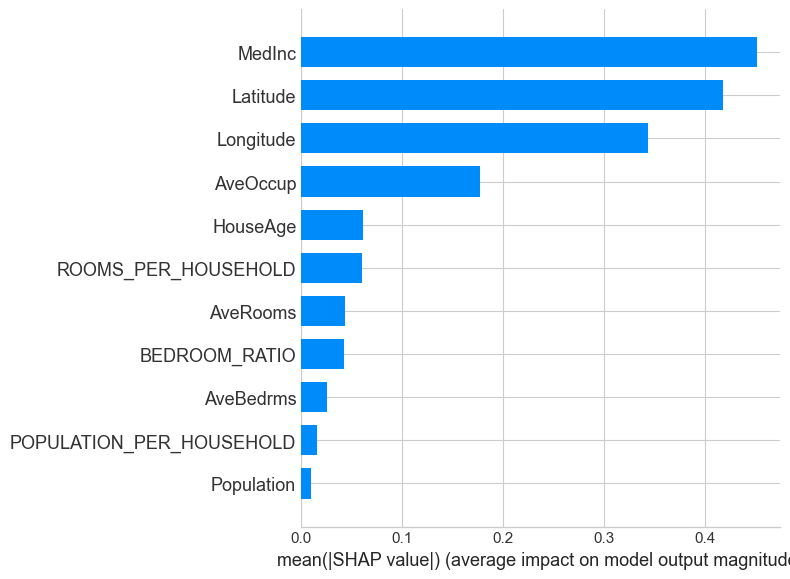

In [ ]:
def interpret_model(model, X_val, model_name):
    explainer = shap.TreeExplainer(model) if model_name in ['RandomForest', 'XGBoost', 'LightGBM'] else shap.KernelExplainer(model.predict, shap.sample(X_val, 100))
    shap_values = explainer.shap_values(X_val)
    
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_val, plot_type='bar')
    plt.show()

best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]

interpret_model(best_model, X_test, best_model_name)


In [55]:
X_test

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,POPULATION_PER_HOUSEHOLD,ROOMS_PER_HOUSEHOLD,BEDROOM_RATIO
14911,-0.175374,0.505394,0.450649,-0.111245,-0.784572,-0.011564,0.518816,-0.139904,-0.830559,0.210217,-0.922833
16468,-0.893827,-0.448103,-0.461507,-0.231053,-0.322735,-0.033960,2.522654,-2.291158,-0.286513,-0.348703,0.296243
3550,0.177089,-1.163225,-0.611157,-0.084482,1.521080,-0.104906,-0.918517,0.823418,2.849600,0.000139,0.977002
1547,0.158981,-1.481058,-0.536554,-0.251597,-0.802233,-0.108518,-0.693788,0.558879,-0.610848,0.116303,0.434989
11356,1.707638,-0.050812,0.566252,-0.173594,-0.524071,-0.064796,-0.937245,0.833401,-0.398984,0.760553,-1.112530
...,...,...,...,...,...,...,...,...,...,...,...
4768,0.325054,-1.083767,0.462495,-0.054824,0.876451,0.003593,1.239823,-1.228009,0.728343,0.120421,-0.864987
3128,-0.996997,-0.130270,-0.704786,-0.068321,0.842012,0.091926,-0.735924,0.898288,0.239224,-0.926236,1.305064
1723,-0.146949,-0.607019,-0.342784,0.023652,-0.002187,-0.011398,-1.012154,0.933227,-0.045877,-0.371135,0.495903
15137,-0.129316,-0.289187,-0.040363,-0.219180,-0.232664,-0.094430,-1.325839,1.242688,0.147678,0.499955,-0.461494


Conclusion:

Based on the model performance evaluation:

1. **XGBoost** performed the best with the lowest Test RMSE (0.485) and the highest R² score (0.829), making it the most accurate model for this task.

2. **LightGBM** was the second-best performer, with a slightly higher Test RMSE (0.487) but a nearly identical MAE to XGBoost.
3. **Random Forest** showed moderate performance but had a significantly higher Test RMSE (0.527) and a lower R² (0.798), indicating less accuracy.
4. Ridge, Lasso, and Linear Regression performed poorly, with the highest Test RMSE (≈0.681) and the lowest R² (≈0.664), making them unsuitable for this dataset. 

Saving Best Trained Model

In [54]:
# Save the trained model
joblib.dump(best_model, "house_price_model.pkl")

print("Model saved successfully as house_price_model.pkl")

Model saved successfully as house_price_model.pkl


In [67]:
# best_model.predict(X_test.head(1))
third_row = X_test.iloc[2:3]
third_row

# Make the prediction for the 3rd row
# prediction = best_model.predict(third_row)
# prediction

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,POPULATION_PER_HOUSEHOLD,ROOMS_PER_HOUSEHOLD,BEDROOM_RATIO
3550,0.177089,-1.163225,-0.611157,-0.084482,1.52108,-0.104906,-0.918517,0.823418,2.8496,0.000139,0.977002
